In [2]:
!pip install praw pandas seaborn scipy

In [1]:
import csv
from datetime import datetime
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import praw
import prawcore
import random
import seaborn as sns
from typing import Callable

from util import *

sns.set_theme()

In [2]:
import logging

# This will log everything
LOG = True
if LOG:
    handler = logging.StreamHandler()
    handler.setLevel(logging.WARN)
    for logger_name in ("praw", "prawcore"):
        logger = logging.getLogger(logger_name)
        logger.setLevel(logging.DEBUG)
        logger.addHandler(handler)

In [6]:
# Create the Reddit instance to do all the API stuff with
reddit = init_reddit()

In [7]:
keywords = [
    "trauma",
    "gaslight",
    "trigger",
    "toxic",
    "woke",
    "manipulat",
    "microaggression",
    "autis",
    "adhd",
    "ocd",
    "ptsd",
    "bipolar",
    "anxiety",
    "depress",
    "psycho",
    "delusion",
    "delulu",
    "solulu",
    "addict",
    "abus",
    "unstable",
    "narcissis",
    "addict",
    "neurodivergen",
]

## Load comments

In [4]:
from datetime import datetime

runs = get_runs()
assert max(runs.keys()) + 1 == len(runs)
df = load_comments(*runs.values())
df.drop_duplicates(inplace=True)
# df["body"] = df["body"].map(str)
# df["id"] = df["name"].map(lambda name: int(name, 36))
# df["time"] = df["time"].map(lambda ts: datetime.fromtimestamp(ts))

# Sort dataframe by ID/time for convenience
# df.sort_values(by="id", inplace=True)
# df.reset_index(drop=True, inplace=True)

df

,id,time,sr_name,author_id,parent_fullname,post_id,upvotes,downvotes,body
0,43535679895,1694370957,itookapicture,9zxaw2zhs,t3_16f7sey,t3_16f7sey,2,0,April 2022 23:52 after the Tyson Fury fight
1,43535740891,1694371456,CautiousBB,NaN,t3_16f3y5s,t3_16f3y5s,3,0,8 weeks is too early for a mucus plug. CM can ...
2,43535775625,1694371722,Music,5oegbwgv,t1_jzyekbk,t3_16expzg,2,0,Yup. Currently anything less than 50 years old...
3,43535905681,1694372685,PipeTobacco,68d7qzqv,t1_k0058na,t3_16exh9j,1,0,Right on! Thanks for the response. Cheers!
4,43535932127,1694372882,MiamiMarlins,gkhz0myc,t3_16f14eg,t3_16f14eg,1,0,Back in the game!
...,...,...,...,...,...,...,...,...,...
1818,45503296680,1711398771,TaylorSwift,94mpbc0j,t1_kwh4y7i,t3_1bn5e3m,1,0,Came here for this one and couldn’t agree more...
1819,45503299358,1711398790,howto,azxzsqxj,t3_1bn9gmj,t3_1bn9gmj,1,0,I have a little bottle for a medicine dispense...
1820,45503314295,1711398897,ynab,rehou,t3_1bnedeu,t3_1bnedeu,4,0,"You're mostly there, but here's what you're mi..."
1821,45503412282,1711399588,science,NaN,t3_1bn8gfq,t3_1bn8gfq,1,0,Uncover? Do they think they’re sleuths? 5 minu...


In [117]:
# The first ID we actually collected
first_id_actual = df["id"].min()
first_id_actual, np.base_repr(first_id_actual, 36)

(26125783434, 'C02M7II')

#### Sanity checks

In [9]:
# Make sure no duplicates got through
assert len(df["name"]) == len(df["name"].drop_duplicates())

In [10]:
# Make sure the IDs are actually sequential
for i in range(len(df) - 1):
    curr = df.iloc[i]
    next = df.iloc[i + 1]
    assert curr.time <= next.time, f"Found out-of-order ID at {i}"

#### Actual analysis

In [11]:
def matches(body, keywords=keywords):
    for keyword in keywords:
        if keyword in body:
            return True
    return False

In [12]:
df["body"] = df["body"].map(lambda body: body.lower().strip())
matched_rows = df[df["body"].map(matches)]
matched_rows

,index,name,subreddit,time,body,id
18,2019,c03vbh4,usa,2008-04-30 13:07:08,what the trauma to the poor child being taken ...,26127888088
34,87349,c04q72l,AskReddit,2008-07-17 12:39:37,word up. people are addicted to feeling stron...,26129328717
59,99228,c06to96,reddit.com,2008-12-14 16:50:33,if you say that it is easier to pull a bag ove...,26132850186
242,53456,c0njvod,politics,2010-04-05 20:15:57,the crucial issue is on what side the folks be...,26160946717
467,88342,c18hj7s,IAmA,2010-12-09 19:14:41,>thanks for this reply! any time! i suppose ...,26196109192
...,...,...,...,...,...,...
103766,87105,jzfocjf,SFGiants,2023-09-06 16:57:46,i think that rings especially true because we ...,43501510779
103896,60735,jzqqpmx,AutisticPride,2023-09-08 19:06:32,for the full implementation of autistic repres...,43520096841
103932,19488,jztla0k,AmItheAsshole,2023-09-09 10:55:46,in order to ensure that services are being use...,43524882164
103981,3398,jzxu4ln,askSouthAfrica,2023-09-10 05:37:02,"honestly, i think there are many different psy...",43532013515


In [16]:
{
    keyword: len(matched_rows[matched_rows["body"].map(lambda body: keyword in body)])
    for keyword in keywords
}

{'trauma': 88,
 'gaslight': 21,
 'trigger': 169,
 'toxic': 137,
 'woke': 74,
 'manipulat': 97,
 'microaggression': 0,
 'autis': 54,
 'adhd': 42,
 'ocd': 21,
 'ptsd': 33,
 'bipolar': 12,
 'anxiety': 145,
 'depress': 204,
 'psycho': 148,
 'delusion': 61,
 'delulu': 0,
 'solulu': 0,
 'addict': 179,
 'abus': 287,
 'unstable': 25,
 'narcissis': 51,
 'neurodivergen': 3}

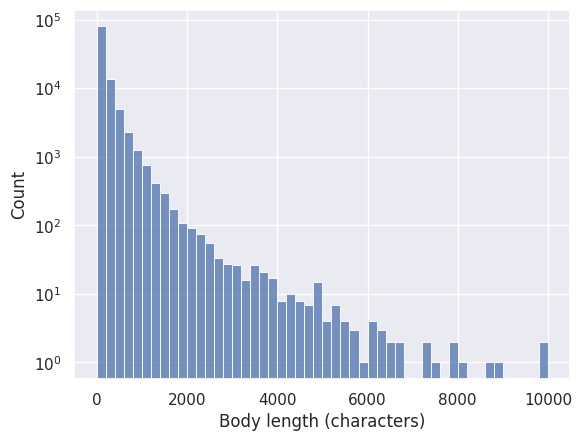

In [17]:
lengths = df["body"].map(len)
ax = sns.histplot(
    lengths[lengths <= 10000],
    binwidth=200,
    # log_scale=True
)
ax.set(xlabel = "Body length (characters)")
ax.set(yscale = "log");

In [18]:
df[lengths >= 10000]

,index,name,subreddit,time,body,id
3874,36385,ca06ttw,mindcrack,2013-05-16 17:51:52,there you go ya bot. okay: will sobriety get k...,26726368388
16124,84499,d5r64yf,Thread_crawler,2016-07-26 02:35:58,mcjfafgb/8v8qrv8n2wcshmgd1wkrjfbex2b7u0u8t8gvi...,28646137239


### Graphing distribution over time

<Axes: xlabel='time', ylabel='Count'>

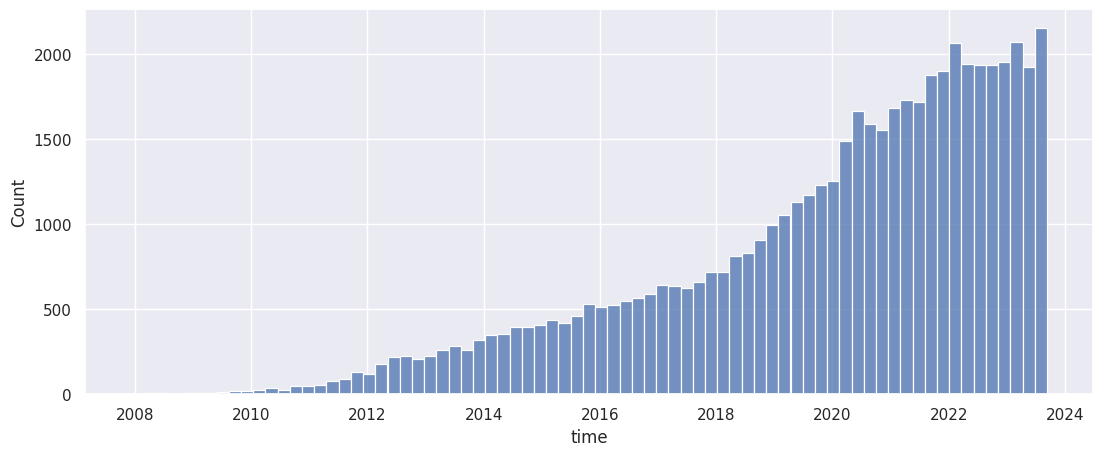

In [118]:
from datetime import timedelta

plt.figure(figsize=(13, 5))
# TODO figure out how to get binwidth to work with timedeltas
sns.histplot(data=df, x="time") #, binwidth=timedelta(days=30))

<Axes: xlabel='time', ylabel='Count'>

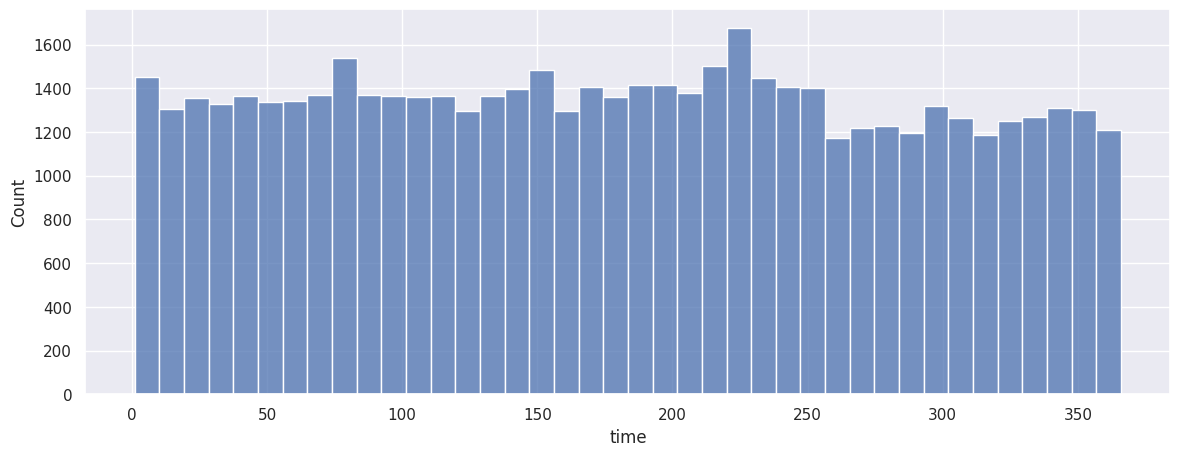

In [119]:
# Number of comments by day of year
plt.figure(figsize=(14, 5))
sns.histplot(data=df["time"].apply(lambda t: int(t.strftime("%j"))))

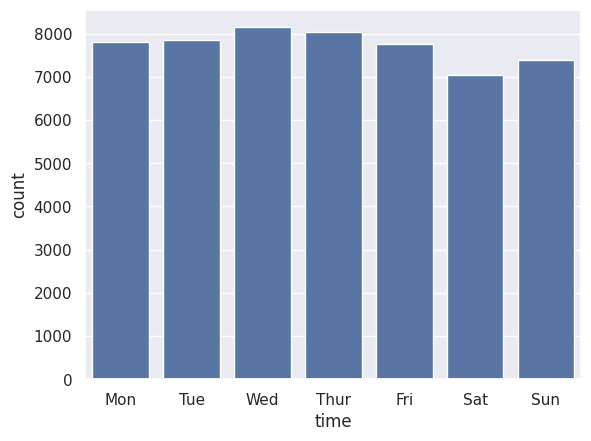

In [120]:
# Number of comments by day of week (0 = Monday)
g = sns.barplot(data=df["time"].apply(lambda t: t.weekday()).value_counts())
g.set_xticks(
    g.get_xticks(),
    labels=[
        ["Mon", "Tue", "Wed", "Thur", "Fri", "Sat", "Sun"][tick]
        for tick in g.get_xticks()
    ],
);

### Are the IDs uniformly distributed?

Figure out if the IDs are uniformly distributed using the Kolmogorov-Smirnov test

TODO check if KS is the right test to use here. Alternatives (not sure if any of these are even applicable):
- Chi-square (we don't have a normal distribution though)
- Mann-Whitney U test
- Anderson-Darling

The fact that we're taking the first gotten comment as the start rather than the actual requested
start ID might screw things up but whatever

<Axes: xlabel='id', ylabel='Count'>

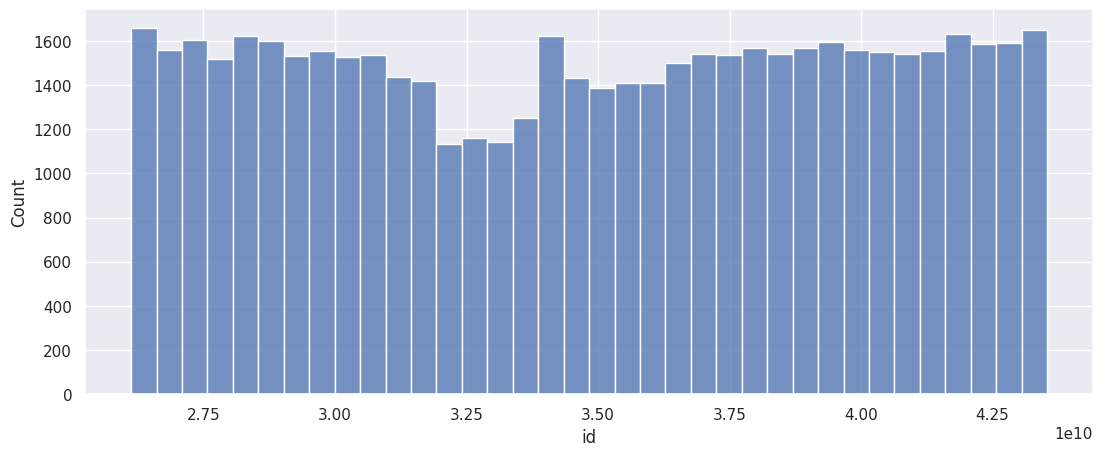

In [122]:
# Distribution of IDs

plt.figure(figsize=(13, 5))
sns.histplot(data=df["id"])

In [123]:
from scipy import stats

# Choose alpha of 0.05

ids_normalized = df["id"].map(lambda id: (id - first_id_actual) / (last_id - first_id_actual))
res = stats.ks_1samp(ids_normalized, stats.uniform.cdf)
if res.pvalue < 0.05:
    print("IDs are probably not uniformly distributed")
else:
    print("IDs are probably uniformly distributed")
res

IDs are probably not uniformly distributed


KstestResult(statistic=0.1111488762810271, pvalue=0.0, statistic_location=0.8888511237189729, statistic_sign=1)

In [124]:
# The earliest comment we have
df[df["id"] == df["id"].min()]

,index,name,subreddit,time,body,id
0,91535,c02m7ii,reddit.com,2007-12-07 11:14:13,"London doesn't do it with every street, and th...",26125783434


In [125]:
misses = pd.Series(int(id, 36) for id in open("misses.txt", "r"))
misses

0          3983123541
1         25698587140
2         18961999379
3         12934330486
4         11977201267
             ...     
190972     8072155589
190973    20945959943
190974    14946264288
190975    18901790547
190976     2805712958
Length: 190977, dtype: int64

<Axes: >

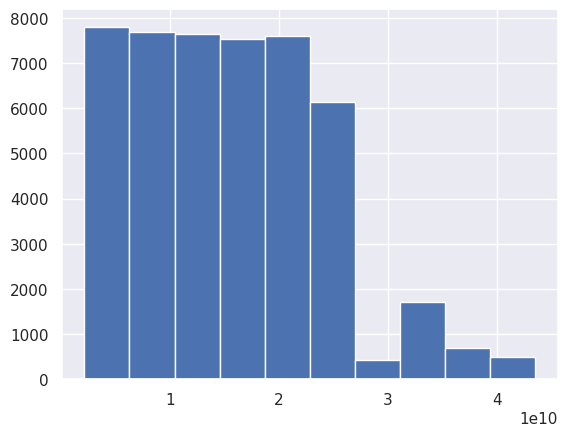

In [130]:
misses.hist()

<Axes: ylabel='Count'>

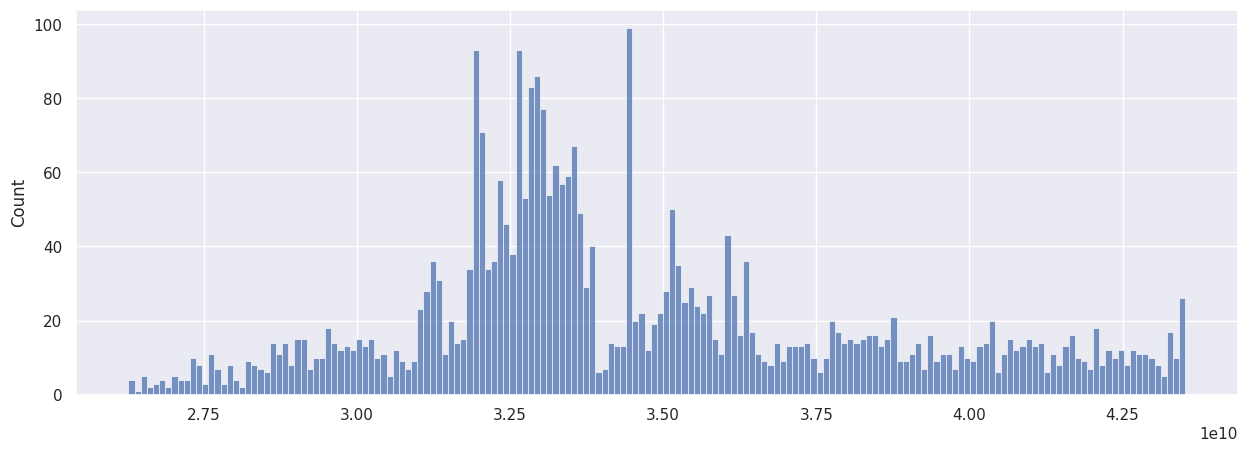

In [131]:
plt.figure(figsize=(15, 5))
misses_actual = misses[misses >= first_id_actual]
sns.histplot(misses_actual, binwidth=1e8)

<Axes: ylabel='Count'>

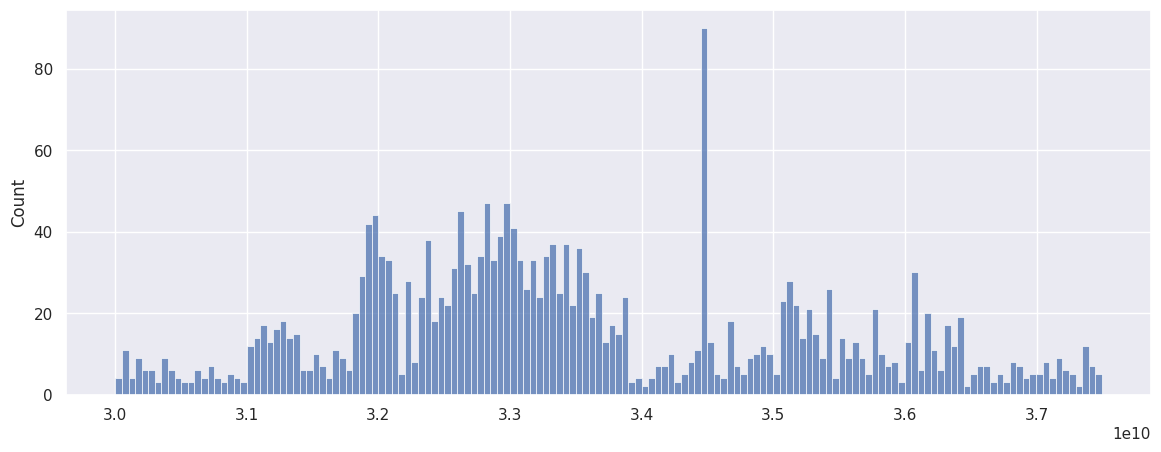

In [132]:
# Zoom in on the middle
# Note: The counts won't match the ones above because the bin width is different

# TODO How are you supposed to filter a series?
weirdos = misses[lambda id: id <= 3.75e10][lambda id: 3e10 <= id]

plt.figure(figsize=(14, 5))
sns.histplot(weirdos, binwidth=5e7)

In [133]:
# What portion of the requests we made actually returned something?
all = len(df) / (len(df) + len(misses))
# Same as above, but don't include requests for comments with IDs that were too low
exclude_invalid = len(df) / (len(df) + len(misses_actual))

all, exclude_invalid

(0.5307616707616708, 0.9425120857257544)

<Axes: xlabel='id', ylabel='rate'>

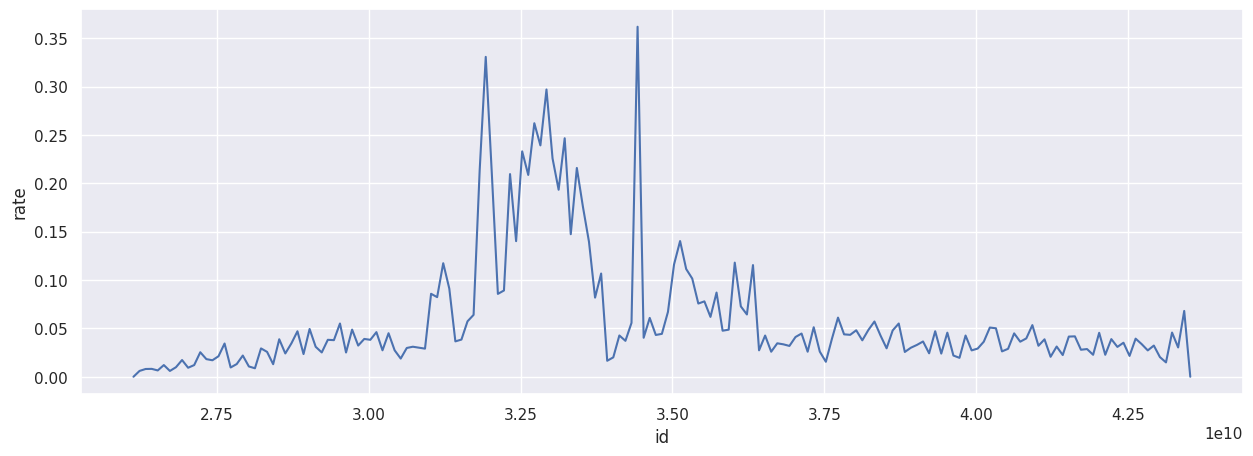

In [149]:
# Hit rate over time
start = first_id_actual
end = max(df.iloc[len(df) - 1]["id"],
          misses.loc[len(misses) - 1])
step = int(1e8)

def get_rate(curr_id):
    next_id = curr_id + step
    hits = len(df[(curr_id <= df["id"]) & (df["id"] < next_id)])
    num_misses = len(misses[lambda id: curr_id <= id][lambda id: id < next_id])

    if num_misses == 0:
        return 0
    return num_misses / (hits + num_misses)

ids = np.arange(start, end, step)
rates = np.fromiter(map(get_rate, ids), dtype=np.dtype(np.float64))

rate_df = pd.DataFrame({ "id": ids, "rate": rates })

plt.figure(figsize=(15, 5))
sns.lineplot(data=rate_df, x="id", y="rate")

In [152]:
df[(3e10 <= df["id"]) & (df["id"] < 3.75e10)]

,name,subreddit,time,body,id
24492,ds58nip,streetwear,2018-01-03 15:55:01,But /u/robonoodle looks much much less like a ...,30000025105
24493,ds5aaqf,sex,2018-01-03 16:21:04,Until death...,30000101847
24494,ds5ewhf,ockytop,2018-01-03 17:37:27,"Kamara consistently called out, had signature ...",30000316659
24495,ds5lihp,EDC,2018-01-03 19:42:40,"That's awesome, good eye for a cool use!",30000625117
24496,ds5m8wm,harrypotter,2018-01-03 19:57:16,"I like that reason though, it feels a little m...",30000659350
...,...,...,...,...,...
66230,h868wzx,prettyaltgirls,2021-08-08 10:37:43,;),37499522829
66231,h86ad6z,miraculousladybug,2021-08-08 10:49:38,Stormy Weather and Evillustrator had cool designs,37499590475
66232,h86as66,Gunners,2021-08-08 10:53:01,"Saliba sees the way out now, he is happy",37499609886
66233,h86c5oi,serbia,2021-08-08 11:04:13,"Nedeljom je drugačiji raspored vožnje, moguće ...",37499674050


In [136]:
from scipy import stats

# Choose alpha of 0.05

misses_normalized = misses_actual.map(
    lambda id: (id - misses_actual.mean()) / (misses_actual.std())
)
res = stats.ks_1samp(misses_normalized, stats.norm.cdf)
if res.pvalue < 0.05:
    print("Misses are probably not normally distributed")
else:
    print("Misses could be normally distributed")
res

Misses are probably not normally distributed


KstestResult(statistic=0.12137782532388652, pvalue=9.498360451644489e-43, statistic_location=-0.19669160654014647, statistic_sign=1)

## Subreddits

In [121]:
df[df["subreddit"] == "reddit.com"]

,index,name,subreddit,time,body,id
0,91535,c02m7ii,reddit.com,2007-12-07 11:14:13,"London doesn't do it with every street, and th...",26125783434
2,101518,c031764,reddit.com,2008-01-30 00:31:42,because it takes all day to vote?,26126482828
3,75169,c035sd1,reddit.com,2008-02-12 08:22:36,"I doubt this will happen, the ISPs will fight ...",26126696917
4,103066,c03e4tj,reddit.com,2008-03-08 19:29:46,I thought the same when I finished the story a...,26127086311
7,97189,c03lq7n,reddit.com,2008-04-01 18:21:39,What does one of hip-hop's most [illustrious p...,26127440627
8,94094,c03tl2a,reddit.com,2008-04-25 10:34:06,The guys they killed all had rap sheets. I do...,26127807202
11,96050,c04bp9c,reddit.com,2008-06-11 22:06:21,"the dad is ""fucked""? maybe he shouldn't have ...",26128652448
12,99116,c04gzsw,reddit.com,2008-06-25 02:31:59,I hope so.,26128899392
13,59575,c04ifpz,reddit.com,2008-06-28 06:09:58,"He ""wants to attack Iran""? Uh. Source please....",26128966679
15,78079,c04qtpi,reddit.com,2008-07-18 19:13:36,this pope is none of that. he is RESPONSIBLE f...,26129358054


In [80]:
# Most popular subreddits
df["subreddit"].value_counts().nlargest(20)

subreddit
AskReddit          5059
politics           1141
funny               747
pics                706
nba                 702
worldnews           691
teenagers           682
nfl                 647
memes               632
gaming              616
soccer              605
AmItheAsshole       595
leagueoflegends     562
news                452
wallstreetbets      440
todayilearned       430
SquaredCircle       404
videos              377
movies              375
hockey              345
Name: count, dtype: int64

# Distributed Sampling?

In [2]:
class Generator:
    def __init__(
        self,
        seed: int,
        end: int,
        step: int,
        iter_num: int = 0,
        id: Optional[int] = None,
    ):
        """
        # Parameters
        * `seed` - Seed to shuffle starts
        * `end` - Where the generator ends
        * `step` - Step size
        * `iter_num` - How many times we've reached `end` (0 for very start)
        * `id` - The last generated id"""

        self.end = end
        self.step = step

        rand = random.Random(seed)
        self.all_starts = list(range(step))
        rand.shuffle(self.all_starts)

        for _ in range(iter_num):
            self.all_starts.pop()

        if id is not None:
            self.id = id
        else:
            self.id = self.all_starts.pop() - step

    def get_state(self):
        iter_num = self.step - len(self.all_starts)
        return (self.seed, self.end, self.step, iter_num, self.id)

    def __next__(self):
        self.id = self.id + self.step
        if self.id <= self.end:
            return self.id

        self.id = self.all_starts.pop()
        return self.id

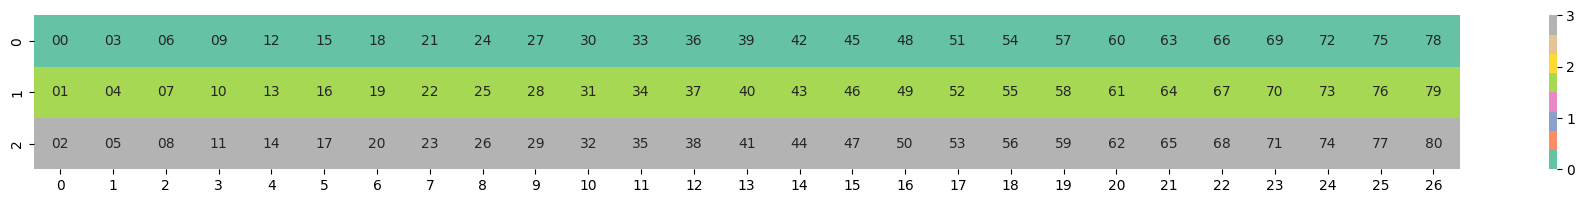

In [54]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns


num_comps = 3
end = num_comps**4  # 81 IDs in all
gens = [
    Generator(seed=i, end=end // num_comps - 1, step=num_comps * num_comps)
    for i in range(num_comps)
]

mat = [[0 for _ in range(end // num_comps)] for _ in range(num_comps)]
ids = [[j * num_comps + i for j in range(end // num_comps)] for i in range(num_comps)]

fig = plt.figure(figsize=(23, 2))

def init():
    sns.heatmap(
        mat,
        vmin=0,
        vmax=len(gens),
        cbar_kws={"ticks": list(range(len(gens) + 1))},
        cmap=sns.color_palette("Set2"),
        annot=ids,
        fmt="02d",
        # square=True,
    )


def animate(i):
    for i, gen in enumerate(gens):
        id = next(gen)
        assert mat[i][id] == 0
        mat[i][id] = i + 1
    sns.heatmap(mat, cbar=False, cmap=sns.color_palette("Set2"))


anim = animation.FuncAnimation(
    fig, animate, init_func=init, repeat=False, frames=end // num_comps,
)
anim.save("foo.mp4")
plt.show()